<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/ceb_m4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 4: PID Control

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    


In [ ]:
!pip install slycot

In [ ]:
!pip install control

This article is contained in Control Engineering Basics study module, which is used as course material for Electrical-Mechanical Manufacturing Engineering (EMME), Department of Mechanical Engineering, Kasetsart University.

### Module Key Study Points
* understand the basics of PID control
* learn the effects of 3 parameters to system response
* learn how response is degraded by integrator windup
* How to tune PID parameters by Ziegler-Nichols Frequency Domain method

In [2]:
import control as ctl # note the slight change from previous modules
import numpy as np
import matplotlib.pyplot as plt

<p />PID stands for Proportional, Integral, and Derivative. It is a standard control structure used successfully in many 
industrial applications. Commercial PID controllers can be bought off the shelf and installed in the system. After some setup 
and tuning the three PID gains, and perhaps some additional parameters, the system is up and running in no time. Of course, 
this means the control engineer is certain the plant can be handled by the PID controller and understand how to adjust the 
control parameters. Without such knowledge, it could be a frustrating experience to her.
<p />So, in this module we discuss some basics of PID control and focus on how to analyze a feedback sysem and simulate. For 
a detailed study, we recommend [1]. For those interested in digital PID implementation,
document [3] might be helpful.  The e-book [4] provides more information on independent robot joint control using
PID.

<h3>Different forms of PID </h3>
<p />The so-called “textbook” form of PID controller is described as follows
\begin{equation} 
u(t) = K\left( e(t) + \frac{1}{T_i}\int_{0}^t e(\tau)d\tau + T_d\frac{de(t)}{dt}\right)
\end{equation}
<div align="right">(1)</div>
<p />This algorithm computes the control variable $u$ as output, given the input $e$, the error between the command and 
plant output.  We see that the control variable is a function of 3 terms: P (proportional to error), I (time integral of error), 
and D (derivative of error), with corresponding control parameters $K$ (proportional gain), $T_i$ (integral time), 
and $T_d$ (derivative time), respectively. Taking Laplace transform of (1), we have
\begin{equation} 
u(s) = C(s)e(s)
\end{equation}
<div align="right">(2)</div>
<p />with the transfer function of PID controller 
\begin{equation} 
C(s) = K\left( 1 + \frac{1}{sT_i} + sT_d\right)
\end{equation}
<div align="right">(3)</div>
<p />Another common structure of PID algorithm is represented by
\begin{equation} 
u(t) = K_pe(t) + K_i\int_{0}^t e(\tau)d\tau + K_d\frac{de(t)}{dt}
\end{equation}
<div align="right">(4)</div>
<p />In this form, the controller gains are distributed to each of the PID terms separately, with its transfer function
\begin{equation} 
C(s) = K_p + \frac{K_i}{s} + K_ds
\end{equation}
<div align="right">(5)</div>
<p />For our discussion of PID controller, we focus on the form (4) and  (5). Nevertheless, it is easy to convert 
between parameters of (1) and (4) by the relations
\begin{equation} 
K_p = K, K_i = \frac{K}{T_i}, K_d = KT_d
\end{equation}
<div align="right">(6)</div>

<p /><b>Example 1: </b> Run this cell to plot  step-response of PID controller with the robot joint plant 
    $P(s) = \frac{1}{10s^2+0.1s}$. Adjust the control gains $K_p, K_i, K_d$ to see their effects.
    

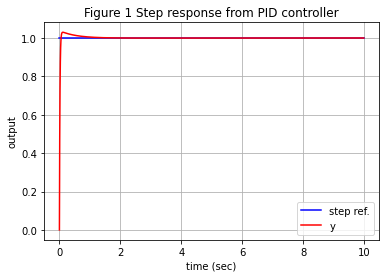

In [123]:
# PID gains. Initially, Try something like Kp=100, Ki=0.01, Kd=40
Kp = 1440
Ki = 500
Kd = 640
# PID controller
cnum = [Kd, Kp, Ki] # note this is an improper transfer function
cden = [1, 0]
C = ctl.tf(cnum,cden)
#print(C)

# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)

tvec = np.arange(0,10,0.01) # adjut time vector if necessary
r = np.ones(tvec.shape)
L = C*P
sys = ctl.feedback(L)
#print(sys)
T, y = ctl.step_response(sys, tvec)

plt.figure()
plt.plot(T,r,'b',T,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.title("Figure 1 Step response from PID controller")
plt.legend(['step ref.','y'])
plt.show()


<p />PID parameter tuning is well studied in control engineering. Here we give a brief guideline. The proportional gain $K_p$ is
a dominant quantity that normally has some nonzero value. The integral gain $K_i$ helps eliminate steady state error but too 
high value could introduce overshoot and oscillation. The derivative gain $K_d$ could help the response to reach steady state 
faster but could amplify high frequency noise, and could affect stability if set too high. 
<p />When the plant model is not known, adjusting these 3 gains to achieve good response could be problematic for an 
inexperienced user. Later we discuss a tuning procedure. Commercial PID controller products usually have auto-tuning functions 
for user convenience.
<p /><b> Example 2: </b>To experiment with the tracking and disturbance attenuation performance of PID control, we setup a 
feedback diagram in Figure 2. 
<p align="center">
<img src="https://drive.google.com/uc?id=1jLwZfC2-p9TIFARL-7Yl8_FgCt3hg-VO" width=600 alt="Figure 2"/>
</p>
<div align="center"><b>Figure 2 PID feedback with input disturbance</b></div>
Such diagram is quite easy to construct using simulation engine like Simulink in MATLAB, or 
Xcos in Scilab. It is more tricky using time-domain simulation function in Python Control Systems library.
<p />First, it can be derived that the transfer function from $D(s)$ to $\theta(s)$ is $P(s)S(s)$. So the disturbance response 
is the output from this transfer function. Suppose that The step disturbance at the plant input is active at half of time 
vector, with step value of 80. Adding the outputs together yields the step response with step disturbanc input.

In [25]:
sys1 = ctl.feedback(L) # system for step command 
S = 1/(1+L)
sys2 = P*S

tvec = np.arange(0,20,0.01) # adjut time vector if necessary
r = np.ones(tvec.shape)
d = 80*np.ones(tvec.shape)
d[:int(len(tvec)/2)] = 0.0
T1, y1 = ctl.step_response(sys1, tvec)
T2, y2, x = ctl.forced_response(sys2, tvec, d)
y = y1 + y2

In [ ]:
<p />Note that in this example, we have the luxury of knowing the exact plant model. So it is possible to solve for a good set
of PID gains. An approach used in [2] turns off the $K_i$  gain first and solve for $K_p$ and $K_d$ that yields 
a critical-damped system at chosen natural frequency.  Then $K_i$ is adjusted to eliminate steady-state error. 
<p />To elaborate, it is shown in [2] that when $K_i$ is set to 0, the resulting second order closed-loop characteristic 
polynomial is described by
\begin{equation} 
s^2 + \frac{(B + K_d)}{J}s + \frac{K_p}{J} = s^2 + 2\zeta\omega s + \omega^2
\end{equation}
<div align="right">(7)</div>
<p />which gives
\begin{equation} 
K_p = \omega^2J, K_d = 2\zeta\omega J - B
\end{equation}
<div align="right">(8)</div>
<p />For example, suppose we select a critical-damped closed loop system $\zeta = 1$, with natural frequency $\omega = 8$. 
From (8), this yields $K_p = 640$ and $K_d = 160$. Table 1 below gives calculated P and D gain values for 3 selected natural 
frequencies.  

| $\omega$ | $K_p$ | $K_d$ |
|----------|-------|------|
| 4 | 160 | 80 |
| 8 | 640 | 160 |
| 12 | 1440 | 240 |



<div align="center">Table 1 $K_p$ and $K_d$ gains for 3 different natural frequencies</div>
<p />Using these 3 sets of gain values, we simulate the step responses.

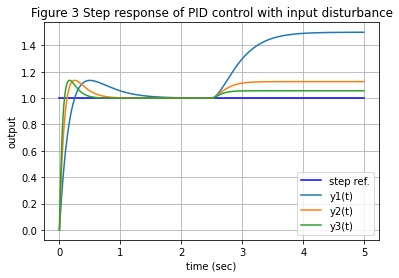

In [56]:
# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)

Kpvec =[160, 640, 1440] # proportional gains
Kdvec = [80, 160, 240] # derivative gains
Kivec = [0,0,0] # integral gains
tvec = np.arange(0,5,0.01) # adjut time vector if necessary
def pid3(P, Kpvec, Kdvec,Kivec,tvec,figno): # write as function to use later
    r = np.ones(tvec.shape)
    d = 80*np.ones(tvec.shape)
    d[:int(len(tvec)/2)] = 0.0
    plt.figure()
    plt.plot(tvec,r,'b') # ref.command
    for i in range(3):
        cnum = [Kdvec[i], Kpvec[i], Kivec[i]] # set Ki =0
        cden = [1, 0]
        C = ctl.tf(cnum,cden)
        L = C*P
        sys1 = ctl.feedback(L) # system for step command 
        S = 1/(1+L)
        sys2 = P*S
        T1, y1 = ctl.step_response(sys1, tvec)
        T2, y2, x = ctl.forced_response(sys2, tvec, d)
        y = y1 + y2
        plt.plot(T1,y)
    plt.grid('True')
    plt.xlabel('time (sec)')
    plt.ylabel('output')
    plt.legend(['step ref.','y1(t)','y2(t)', 'y3(t)'])
    plt.title("Figure "+str(figno)+" Step response of PID control with input disturbance")
    plt.show()
pid3(P, Kpvec, Kdvec, Kivec, tvec,3)    

<p />The results are as expected, the higher the natural frequency, the faster the response. We also see
that the steady-state error from step disturbance cannot be attenuated with the PD controller. 
<p />To fix this problem, we need to turn on the $K_i$ gain of PID controller. With the controller transfer function described by (5),  the closed-loop system is now of third order
\begin{equation} 
\theta (s) = \frac{K_ds^2 + K_ps + K_i}{\Lambda (s)}\theta_d(s) - \frac{s}{\Lambda (s)}D(s)
\end{equation}
<div align="right">(9)</div>
<p />with the characteristic polynomial
\begin{equation} 
\Lambda (s) = Js^3 + (B + K_d)s^2 + K_ps + K_i 
\end{equation}
<div align="right">(10)</div>
<p />Applying Routh-Hurwitz criteria to (10), it can be concluded that, given all positive PID gains, the feedback system 
is stable if
\begin{equation} 
K_i < \frac{(B + K_d)K_p}{J}
\end{equation}
<div align="right">(11)</div>
<p />To simulate, the same code in the previous cell can be modified by putting some positive integral gain in the PID block. 
Let us fix $K_p = 640$ and $K_d = 160$, corresponding to natural frequency  $\omega = 8$ rad/s. Then vary $K_i$ among 3 
choices, say, 
$K_i = 100, 600, 2500$. We see that disturbance response is reduced with increasing $K_i$, 
though higher value introduces more oscillation and overshoot. 

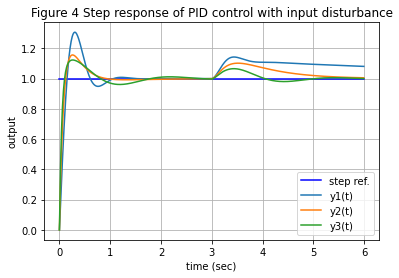

In [57]:
# robot-joint plant
#pnum = 1
#pden = [10, 0.1, 0]
#P = ctl.tf(pnum,pden)

Kpvec = [640, 640, 640]
Kd = [160, 160, 160]
Kivec = [100, 600, 2500]
tvec = np.arange(0,6,0.01) # adjut time vector if necessary
pid3(P, Kpvec, Kdvec, Kivec, tvec,4)     

<p />Applying the bound (11) to this example yields
$$
K_i < \frac{(B + K_d)K_p}{J} = \frac{(0.1 + 160)640}{10} = 10246.4
$$
<p />The reader can verify by setting $K_i = 10246.4$ and plot the step response. The oscillating response in Figure 5 shows 
that the closed-loop system is at the brink of stability.
<p align="center">
<img src="https://drive.google.com/uc?id=116l6iU1mZJzC35NFEFT1veF6qsmVtVzi" width=600 alt="Figure 5"/>
</p>

<h3>Tuning the PID Parameters</h3>
<p />As stated before, adjusting the PID gains from scratch to achieve a good response may not be trivial. As a 
result, most commercial PID controllers have functions to tune the 3 parameters automatically. This is normally 
called “autotuning” feature. One of autotuning methods suggested in the literature makes use of some relay 
feedback mechanisms, which is closely related to a manual tuning scheme known as 
<em>Ziegler-Nichols Frequency Domain (ZNFD) method</em>. Hence we discuss this ZNFD scheme in the last part of this 
module.
<p /><b> Note: </b> The original ZNFD method applies the “textbook” PID equation (1). But since (1) and (4) are 
closely-related by (6), here we make a conversion so that more commonly used PID form (4)
is conveniently used. 
<p />To tune a PID controller manually by ZNFD method, follow this procedure
<ul>
<li>turn off both the integral and derivative terms; i.e., setting $K_i = K_d = 0$. So now the PID is left only 
with the proportional gain $K$. We crank $K$ up to the point that the closed-loop system starts to oscillate. 
At this point, the plant output will swing in a constant sinusoid motion, not growing and not dying out. Write this 
value down on a paper as $K_u$. </li>
<li>Measure the period of oscillation. Write it down as $T_u$. </li>
<li>Use Table 2 to tune the controller parameters</li>
</ul>

| Controller Form | $K_p$ | $K_i$ | $K_d$ |
| :-------------: | :-----: | :------: | :-----: |
| P | $0.5K_u$ | N/A | N/A  |
| PI | $0.4K_u$ | $0.5K_u/T_u$ | N/A |
| PID | $0.6K_u$ | $1.2K_u/T_u$ | $0.075K_uT_u$ |

<div align="center">Table 2: suggested PID parameters from ZNFD method</div>
<p />From the above procedure, we could observe a drawback of the basic ZNFD method: the system must oscillate 
at some point of gain setting before it becomes unstable. This implies the Nyquist plot must cross the negative 
real axis at some point. For the DC motor model we are using, the gain margin is infinity. Hence it is difficult 
to find the oscillating point and the $K_u$ value. 
<p /><b>Note: </b> in a real plant controlled by a PID algorithm, inherent dynamics such as loop delay can help.
<p />There is some trick to get around such limitation, but this is beyond the scope of this module. For our basic 
study, we simply modify the DC motor robot joint by adding some dynamics to it, so that the Nyquis plot 
of $L(j\omega)$ crosses the negative real axis. 


<p /><b> Example 4: </b> From module 1 we observe that the bandwidth for this robot joint is around 0.1 Hz, which 
is quite low. So, Let us feed the PID output through a LPF with cutoff frequency 100 Hz 
before the plant input. Using the filter design guide from module 1, we have the LPF transfer function as
\begin{equation} 
H(s) = \frac{1}{0.0016s + 1}
\end{equation}
<div align="right">(12)</div>
<p />Cascading the PID with LPF yields a new controller
\begin{equation} 
C(s) = \frac{1}{0.0016s+1}\frac{K_ds^2+K_ps+K_i}{s} = \frac{K_ds^2+K_ps+K_i}{0.0016s^2+s}
\end{equation}
<div align="right">(13)</div>
<p />This also helps make $C(s)$ a proper transfer function.
<p /> 
With this model, we are ready to perform the ZNFD tuning procedure described above. 
Click on the PID block to set the I and D gains to zero. Then start increasing the P gain until the output oscillates.
This is what you must do in a real application when the plant model is not known. 
<p />Try the ZNFD process with the provide code in the cell below. (To accommodate further development, the closed 
loopsystem is formulated to a function.)

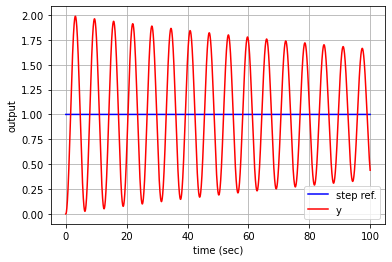

In [31]:
#Experiment with the ZNFD process
Kp = 10
Ki = 0
Kd = 0

# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)
tvec = np.arange(0,100,0.01) # adjut time vector if necessary

# PID controller function
def pid_with_filter(Kp, Ki, Kd, P, tvec):
    cnum = [Kd, Kp, Ki] 
    cden = [0.0016, 1, 0]
    C = ctl.tf(cnum,cden)

    
    r = np.ones(tvec.shape)
    L = C*P
    sys = ctl.feedback(L)
    #print(sys)
    T, y = ctl.step_response(sys, tvec)

    plt.figure()
    plt.plot(T,r,'b',T,y,'r-')
    plt.grid('True')
    plt.xlabel('time (sec)')
    plt.ylabel('output')
    
    plt.legend(['step ref.','y'])
    plt.show()
    
pid_with_filter(Kp, Ki, Kd, P, tvec)

<p />Well, in this example we do know the plant model, don’t we? So, to save us some time, the $K_u$ value that causes
output oscillation can be found. First form the loop transfer function containing the plant, LPF, and PID controller 
with $K_p = 1$, and use Nyquist plot to observe how far $L(j\omega)$ from the critical point -1

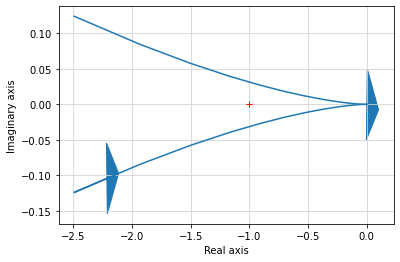

In [33]:
Kp = 1
Ki = 0
Kd = 0
# PID controller
cnum = [Kd, Kp, Ki] 
cden = [0.0016, 1, 0]
C = ctl.tf(cnum,cden)

# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)
L = C*P
real, imag, freq = ctl.nyquist_plot(L,omega=[0.2,100])

Indeed, gain margin is the quantity that dictates much gain can be increased until $L(j\omega)$ touches the critical 
point. It can be computed using the function <em>margin()</em>. Plot the Nyquist diagram again with $K_p$ equals this value to
verify that the curve of $L(j\omega)$ passes through -1.

In [34]:
gm,_,_,_ = ctl.margin(L)
print(gm)

62.501000000000026


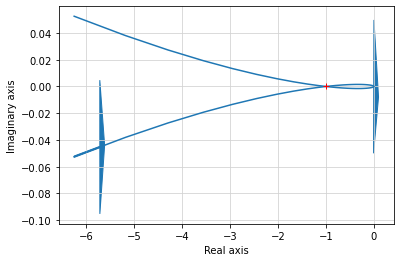

In [40]:
Kp = 62.5
Ki = 0
Kd = 0
# PID controller
cnum = [Kd, Kp, Ki] 
cden = [0.0016, 1, 0]
C = ctl.tf(cnum,cden)
# use the same robot joint P(s) from above
L = C*P
real, imag, freq = ctl.nyquist_plot(L,omega=[1,100])

Hence, $K_u = 62.51$. Using the previous code for ZNFD process, verify that this value yields the desired oscillatory
response. The oscillation period can be roughly measured from the plot to yield $T_u = 8$ sec. 

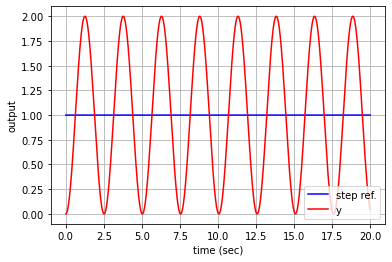

In [41]:
Kp = 62.5
Ki = 0
Kd = 0
tvec = np.arange(0,20,0.01) # adjut time vector if necessary
pid_with_filter(Kp, Ki, Kd, P, tvec)

<p />So from the last row of Table 2, ZNFD method suggests the three PID parameters as 
$$
K_p = 0.6 \times 62.5 = 37.5, K_i = 1.2 \times 62.5 / 8 = 9.38, K_d = 0.075 \times 62.5 \times 8 = 37.5.
$$ 
<p />Setting these values for PID parameters yields the following response

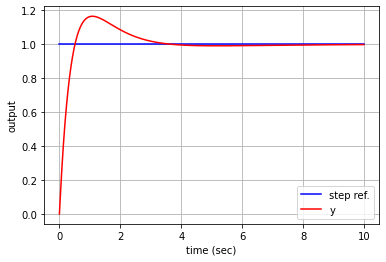

In [49]:
Kp = 37.5
Ki = 9.38
Kd = 37.5
tvec = np.arange(0,10,0.01) # adjut time vector if necessary
pid_with_filter(Kp, Ki, Kd, P, tvec)

<p />In a sense, ZNFD just gives us some good values to start with. We may want to fine-tune the PID gains to 
improve the response further. For example, decreasing the $K_i$ gain would bring the overshoot down. 
<p />The ZNFD method could be explained using a Nyquist diagram in Figure 6. The diagram shows how a point $x$ on 
the curve is moved related to the P, I , and D terms. Using the P term alone, x could be moved in radial direction 
only. The I and D terms help provide more freedom to move perpendicular to the radius. It can be shown that by 
using ZNFD method, the critical point $(-1/K_u, 0)$  is moved to the point $-0.6 – 0.28i$. The distance of this 
point to the critical point is 0.5. So the sensitivity peak is at least 2. This explains the high overshoot in 
the step response. 
<p align="center">
<img src="https://drive.google.com/uc?id=1pqUM3zbz3DFfj7u6Z3G60KZ8dKRyJ4Js" width=450 alt="Figure 6"/>
</p>
<div align="center"><b>Figure 6 How a point on Nyquist curve is moved with PID control</b></div>
<p />From the above procedure, we could observe some drawbacks of the basic ZNFD method. 
<ul>
<li />The system must oscillate at some point of gain setting before it becomes unstable. This implies the Nyquist 
plot must cross the negative real axis at some point. For the DC motor model we are using, the gain margin is 
infinity. (That's why in Example 4 a LPF is added to$L(s)$) Hence in theory we cannot find an oscillating point 
for any $K_u$ value. As mentioned before, fortunately, in a real motor there are some other dynamics involved 
that makes the the Nyquist plot of L(j) crosses the negative real axis.
<li />The process requires that a user adjusts $K_p$ to the exact oscillating point. Increasing the gain only a little 
above that value results in unstable closed-loop system, which could be hazardous. This causes the ZNFD manual method 
become problematic. Some auto-tuning method is based on the manual 
ZNFD, which can make the closed-loop system oscillate without the risk of instability [1]. This is briefly discussed 
below.
</ul>

<h3>Automatic Tuning using Relay Feedback</h3>
<p />From the disadvantage of manual ZNFD tuning mentioned that requires user , we would prefer to obtain plant output oscillation 
without destabilizing the system. A relay feedback helps us achieve just that.
<p />As shown in Figure 7, when a relay is put in place of a controller, it could cause the plant output to oscillate. This is true for a plant with its Nyquist plot crossing the negative real axis. If this is not the case, a relay with hysteresis may be used. Generally speaking, for a plant with order greater than 2, a simple relay can be applied. 
A relay is a nonlinear device. To analyze relay feedback as a linear system, a technique called describing function 
can be applied. See our online article, or [1] for detailed analysis. Here we only summarize the result. 
<p align="center">
<img src="https://drive.google.com/uc?id=1kjQYk9mjzkWV7YNa5MyysGT8AzVCp21o" width=600 alt="Figure 7"/>
</p>
<div align="center"><b>Figure 7 feedback system with relay</b></div>
<p />For a non-hysteresis relay, its describing function is
$$
N(a) = \frac{4d}{\pi a}
$$
<div align="right">(14)</div>
<p />Where $d$ and $a$ are the relay amplitude and plant output magnitude of oscillation, respectively. At the 
oscillation point, the Nyquist curve must intersect the negative axis at $-1/N(a)$. It concludes that the ultimate 
gain $K_u$ equals $N(a)$. $T_u$ can then be measured as before. 
<p />Simulating this nonlinear feedback system in Python is quite a challenge and is left as an exercise. It is easier
to create a model in Scilab or MATLAB.


<h3>Derivative term replacement</h3>
<p />The discussion thus far mentions only a standard PID structure in the form (4) consisting of only 3 basic terms. 
A practical PID controller may include some additional features to cope with inherent problems such as high-frequency 
noise.
<p />One problem with a pure derivative term in (4) concerns high-frequency noise amplification. To elaborate, 
suppose at the controller input there exists some noise component at frequency 1000 rad/sec, with unit amplitude
$$
e(t) = sin(1000t)
$$
With $K_d = 1$, this yields the output of derivative term as
$$
u_d(t) = \frac{d}{dt}sin(1000t)=1000cos(1000t)
$$
Note that the noise a amplified 1000 times! A solution to lessen this effect is to replace the pure derivative with 
a high-pass filter [1]. So the modified PID can be represented in transfer function form as
$$
C(s) = K_p + \frac{K_i}{s} + \frac{NK_d}{N/s+1}
$$
<div align="right">(15)</div>
<p />With small $s$ (low frequency), the third term approximately equals $K_ds$, while at large $s$ (high frequency),
the gain of the third term is limited by $NK_d$. 
<br>Observe bode plot of the derivative term in (14) by running this cell. Vary the values of $N$ and $K_d$ to see 
their effects on frequency response.


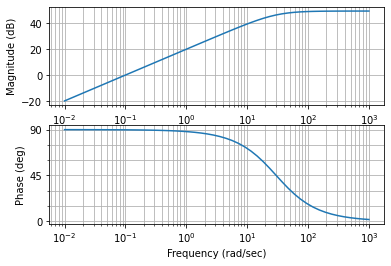

In [118]:
N = 30
Kd = 10
dnum = [N*Kd,0]
dden = [1, N]
Dtf = ctl.tf(dnum,dden)
mag, ph, om = ctl.bode_plot(Dtf, dB=True,omega_limits=(0.01,1000))

<b>Example 7: </b>With the same robot joint plant $P(s) = \frac{1}{10s^2+0.1s}$, compare the step response between 
the original PID (4) and the modified PID (15)

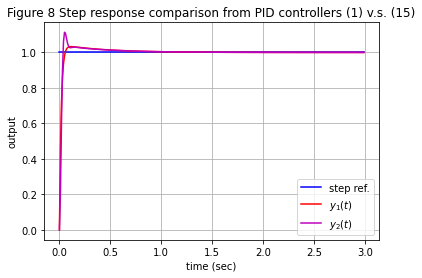

In [120]:
# PID gains. 
Kp = 1440
Ki = 200
Kd = 600

# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)

# Original PID controller (4)
c1num = [Kd, Kp, Ki] # note this is an improper transfer function
c1den = [1, 0]
C1 = ctl.tf(c1num,c1den)

# Modified PID controller (15)
N = 100
c2num = [Kp+N*Kd, Kp*N+Ki, Ki*N] 
c2den = [1, N, 0]
C2= ctl.tf(c2num,c2den)


tvec = np.arange(0,3,0.01) # adjut time vector if necessary
r = np.ones(tvec.shape)
L1= C1*P
sys1 = ctl.feedback(L1)
L2 = C2*P
sys2= ctl.feedback(L2)
T, y1 = ctl.step_response(sys1, tvec)
T, y2 = ctl.step_response(sys2, tvec)

plt.figure()
plt.plot(T,r,'b',T,y1,'r-',T,y2,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.title("Figure 8 Step response comparison from PID controllers (1) v.s. (15)")
plt.legend(['step ref.','$y_1(t)$', '$y_2(t)$'])
plt.show()


<h3>Effect from Saturation</h3>
<p />Analysis of PID feedback control is often performed under the assumption that the system is purely linear. 
In real devices, nonlinear elements emerge at certain points in the feedback loop. Saturation, 
shown in Figure 9, is one of them that 
could cause undesirable system response. This nonlinear effect normally results from physical limits of signals and 
system parameters, say, maximum motor torque and current. Another common saturation is the input limit of servo 
amplifier. An industrial servo amp might allow input voltage command in the range $\pm 10$ volts, for example. 
<p align="center">
<img src="https://drive.google.com/uc?id=1AGpNLsHs8TNMzomGQ-Cj01Tw1r-hzR4d" width=500 alt="Figure 9"/>
</p>
<div align="center"><b>Figure 9 feedback system with saturation</b></div>

<p />Effect from saturation is more pronounced when integral term is used in PID. The response could have excessive 
overshoot due to error accumulation in the integral term. This is known as  <em>integrator windup</em>. See [1] for 
more detail. 

<p /><b> Example 8: </b> To see an effect from input saturation, run the code cell below to compare the closed-loop 
response with and without saturation. The feedback interconnection involves nonlinear input-output system. Don't worry 
if you don't understand all the code provided here.
<p />The controller gains are set at $K_p = 640, K_i = 600, K_d = 160$ . Running the simulation yields the step 
responses in Figure 10. We see that input saturation causes significantly larger overshoot.


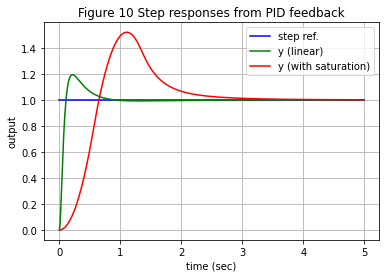

In [121]:
# use PID with LPF
Kp = 640
Ki = 600
Kd = 160
# PID controller
cnum = [Kd, Kp, Ki] 
cden = [0.016, 1, 0]
C = ctl.tf(cnum,cden)
#print(C)

# robot-joint plant
pnum = 1
pden = [10, 0.1, 0]
P = ctl.tf(pnum,pden)

tvec = np.arange(0,5,0.01) # adjut time vector if necessary
r = np.ones(tvec.shape)

def limiter(t, x, u, params):
    return x

def lim_out(t, x, u, params):
    a = params.get('a',50)
    return np.clip(u,-a,a)

io_limsys = ctl.NonlinearIOSystem(limiter, lim_out, inputs=('u'), outputs=('ulim'), states=('x'),name='limiter')

io_Psys = ctl.LinearIOSystem(ctl.tf2ss(P))
io_Csys = ctl.LinearIOSystem(ctl.tf2ss(C))

io_Lsys = io_Psys*io_limsys*io_Csys
io_Lsys_nolim = io_Psys*io_Csys


ss_unity = ctl.ss(0,0,0,1)
io_unity = ctl.LinearIOSystem(ss_unity)

io_clsys = ctl.feedback(io_Lsys, io_unity)
io_clsys_nolim = ctl.feedback(io_Lsys_nolim, io_unity)

T,y_nolim = ctl.input_output_response(io_clsys_nolim, tvec,r)
T,y = ctl.input_output_response(io_clsys, tvec,r)
plt.figure()
plt.plot(T,r,'b',T,y_nolim,'g-',T,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.title("Figure 10 Step responses from PID feedback")
plt.legend(['step ref.','y (linear)', 'y (with saturation)'])
plt.show()


<h3>PID control with anti-windup scheme</h3>
<p />In the above section, we study effect of saturation in the integral term of a PID controller. To recapitulate, 
integrator windup happens when the integral term is used with some nonlinear saturation in the loop, such as when a 
physical variable reach its limit. When that happens, the feedback loop breaks, causing error accumulation in the 
integrator.  This results in worse step and disturbance responses than the case of pure linear system. 
To combat with the detrimental windup effects, a commercial PID controller often has some additional function called 
anti-windup. Here we briefly mention one method called <em>back calculation</em>.
<p />Back calculation anti-windup scheme can be viewed as supplying a supplementary feedback path around the 
integrator. This feedback becomes active and helps stabilize the integrator only when the main feedback loop is 
open due to saturation. This scheme is depicted in Figure 11.
<p align="center">
<img src="https://drive.google.com/uc?id=1hnRxAFdx3HXJF5FpE4SE0DBvIXdHQ2l3" width=550 alt="Figure 11"/>
</p>
<div align="center"><b>Figure 11 back calculation anti-windup scheme</b></div>

<p />An empty cell is provided below in case you want to add this anti-windup scheme to the PID control. ;)

<h3>Summary</h3>
<p />PID is a simple control structure that is still used widely in various industrial applications. It is a close 
relative to the lead-lag compensator explained in module 2, except that its functionality may be more user-friendly.
With some knowledge and practice, an engineer or technician would be able to tune and operate a plant equipped with 
PID control.  
<p />In this module we discuss the basics of PID feedback systems, with emphasis on time-domain simulations to show how 
the responses are related to three control parameters, as well as effect from input saturation that could worsen the 
response. Without some good starting values, tuning the PID gains can be cumbersome for a novice. Therefore, we 
mention a manual tuning procedure known as the Ziegler-Nichols frequency domain method. Some auto-tuning scheme of a 
commercial PID controller, such as the relay feedback method, is based on the ZNFD manual tuning. 

<h3>References</h3>
<ol>
<li>K.J. Astrom and T.Hagglund. PID Controllers, 2nd ed., Instrument Society of America, 1995.</li>
<li>M.W.Spong, S. Hutchinson and M. Vidyasagar,  Robot Modeling and Control. John Wiley & Sons. 2006. </li>
<li>V. Toochinda. Digital PID Controllers,  2009. </li>
<li>V.Toochinda. Robot Analysis and Control with Scilab and RTSX</a>. Mushin Dynamics, 2014. </li>
</ol>

<div align="right">Last update : Jan 9, 2021</div>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>